In [1]:
import pandas as pd
from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json

In [2]:
df = pd.read_csv('../data/baltimore_crime.csv')
df.columns = ['ds', 'y']
df.loc[df['y'] > 250, 'y'] = None

model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [3]:
with open('baltimore_crime_model.json', 'w') as file_out:
    json.dump(model_to_json(model), file_out)

In [4]:
with open('baltimore_crime_model.json', 'r') as file_in:
    model = model_from_json(json.load(file_in))

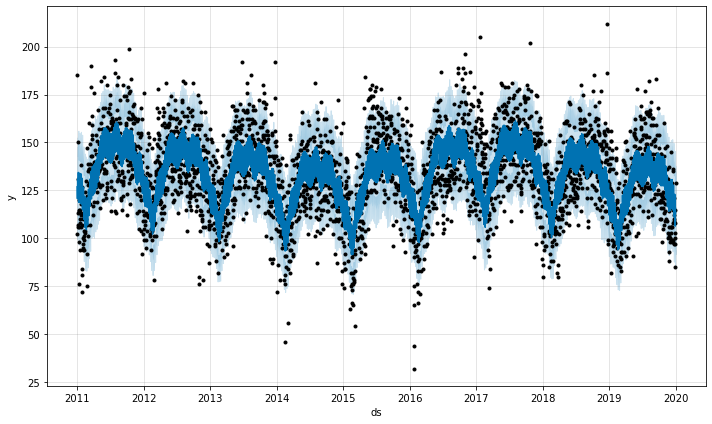

In [5]:
forecast = model.predict()
fig = model.plot(forecast)

In [6]:
df_yesterday = df[df['ds'] < df['ds'].max()]

In [7]:
model1 = Prophet().fit(df_yesterday)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
model2 = Prophet().fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
import numpy as np

class stan_init:
    def __init__(self, model):
        self.params = {
            'k': np.mean(model.params['k']),
            'm': np.mean(model.params['m']),
            'sigma_obs': np.mean(model.params['sigma_obs']),
            'delta': np.mean(model.params['delta'], axis=0),
            'beta': np.mean(model.params['beta'], axis=0)
        }
    def __call__(self):
        return self.params

In [10]:
model2 = Prophet().fit(df, init=stan_init(model1))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
model1 = Prophet().fit(df)
model2 = Prophet(mcmc_samples=200).fit(df, init=stan_init(model1))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
from datetime import timedelta
import plotly.offline as py
py.init_notebook_mode()

In [13]:
df = pd.read_csv('../data/divvy_daily.csv')
df = df[['date', 'rides', 'temperature']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temp']

In [14]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.add_regressor('temp')

model.fit(df[df['ds'] < df['ds'].max() - timedelta(weeks=2)])

future = model.make_future_dataframe(periods=14)
future['temp'] = df['temp']
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
from fbprophet.plot import (
    plot_plotly,
    plot_components_plotly,
    plot_forecast_component_plotly,
    plot_seasonality_plotly
)

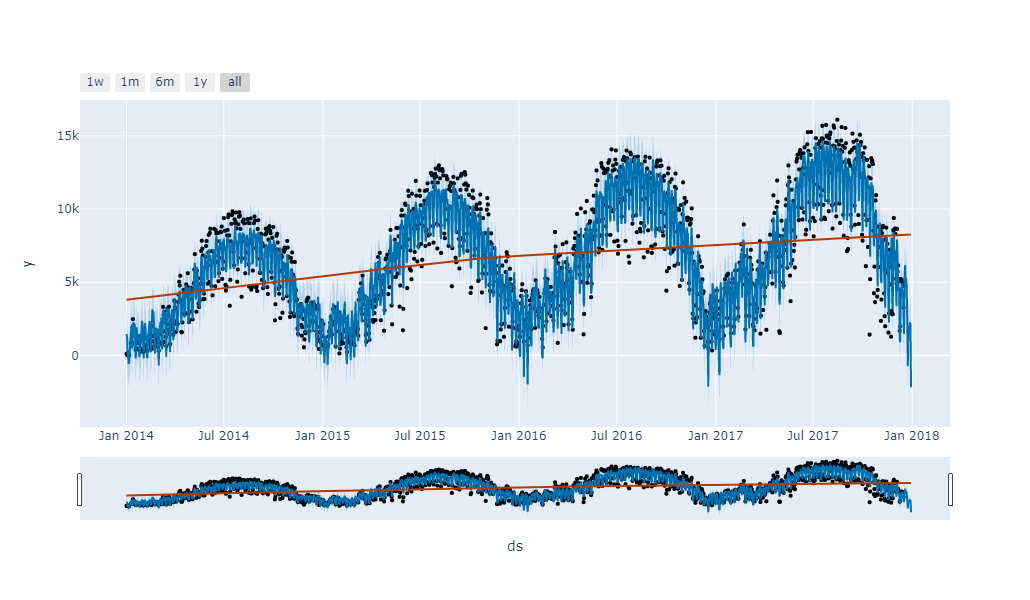

In [16]:
fig = plot_plotly(model, forecast, trend=True)
py.iplot(fig)

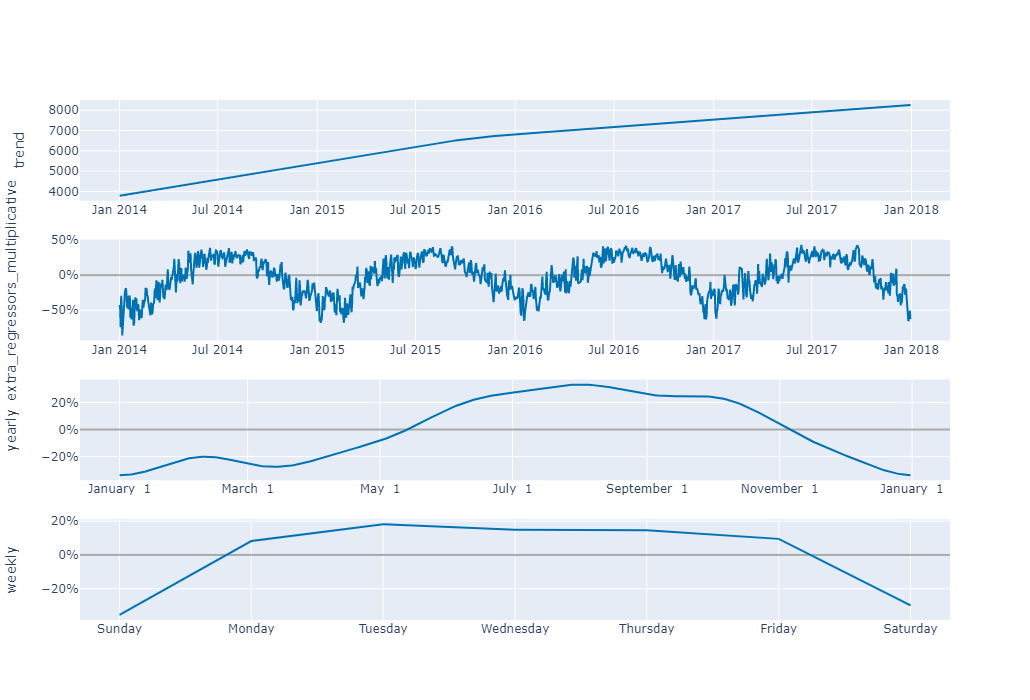

In [17]:
fig = plot_components_plotly(model, forecast , figsize=(800, 175))
py.iplot(fig)

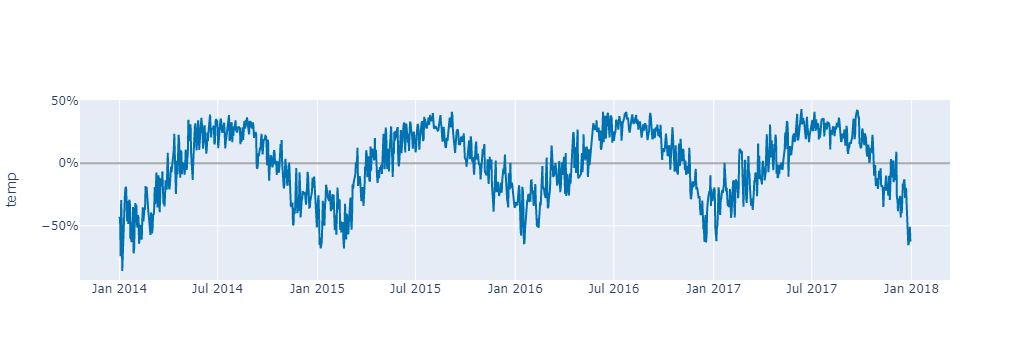

In [18]:
fig = plot_forecast_component_plotly(model, forecast, 'temp')
py.iplot(fig)

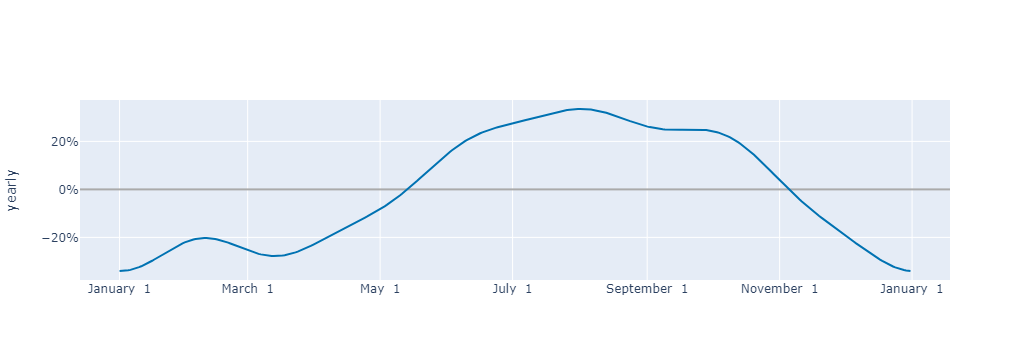

In [19]:
fig = plot_seasonality_plotly(model, 'yearly')
py.iplot(fig)